In [ ]:
%pip install numpy pandas tensorflow scikit-learn matplotlib

  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/ed/8c/87ddf1fcb55d11f9f847e3c69bb1c6f8e46e2f40ab1a2d2abadb2401b007/pandas-2.2.3-cp311-cp311-win_amd64.whl.metadata
  Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/a1/a6/c5b78606743a1f28eae8f11973de6613a5ee87366796583fb74c67d54939/scikit_learn-1.6.1-cp311-cp311-win_amd64.whl.metadata
  Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl.metadata (15 kB)
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/d7/68/0d03098b3feb786cbd494df0aac15b571effda7f7cbdec267e8a8d398c16/matplotlib-3.10.1-cp311-cp311-win_amd64.whl.metadata
  Using cached matplotlib-3.10.1-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Obtaining dependency information for pytz>=2020.1 from https://files.pythonhosted.org/packages/81/c4/34e93fe5f5429d7570ec1fa436f1986fb1


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Load your JSON intents file into a DataFrame
with open("dataset.json", "r") as f:
    data = json.load(f)

rows = []
for intent in data["intents"]:
    tag = intent["tag"]
    for pattern in intent.get("patterns", []):
        rows.append({"text": pattern, "tag": tag})

df = pd.DataFrame(rows)

# 2. Clean & shuffle
df["text"] = (
    df["text"]
    .str.lower()
    .str.replace(r"[^a-z0-9\s]", "", regex=True)
)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 3. Drop any tags with fewer than 2 examples
counts = df["tag"].value_counts()
rare_tags = counts[counts < 2].index.tolist()
if rare_tags:
    print(f"Dropping tags with <2 examples: {rare_tags}")
    df = df[~df["tag"].isin(rare_tags)].reset_index(drop=True)

# 4. Encode labels and split
le = LabelEncoder()
df["label"] = le.fit_transform(df["tag"])

X_train, X_val, y_train, y_val = train_test_split(
    df["text"],
    df["label"],
    test_size=0.2,
    stratify=df["label"],  # now safe because every class has ≥2 samples
    random_state=42
)

print(f"Train size: {len(X_train)}, Val size: {len(X_val)}")

Dropping tags with <2 examples: ['fact-18', 'fact-16', 'fact-28', 'fact-24', 'fact-8', 'no-response', 'fact-21', 'fact-27', 'fact-29', 'fact-30', 'fact-31', 'fact-25', 'fact-17', 'fact-15', 'fact-9', 'fact-14', 'fact-19', 'fact-12', 'fact-23', 'fact-22', 'fact-13', 'fact-10', 'fact-20', 'fact-11']
Train size: 4984, Val size: 1247


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Hyperparams
max_vocab = 5_000
max_len   = 50

vectorizer = TextVectorization(
    max_tokens=max_vocab,
    output_sequence_length=max_len,
    standardize="lower_and_strip_punctuation",
    split="whitespace"
)

# Adapt on training texts
vectorizer.adapt(X_train.values)

# Build tf.data datasets
def make_dataset(texts, labels, batch_size=32, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    if shuffle:
        ds = ds.shuffle(1_000, seed=42)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train.values, y_train.values, shuffle=True)
val_ds   = make_dataset(X_val.values,   y_val.values)

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, Input

# Constants
embedding_dim = 128
num_classes   = len(le.classes_)

# Build model
inputs = Input(shape=(1,), dtype=tf.string)
x = vectorizer(inputs)
x = Embedding(input_dim=max_vocab, output_dim=embedding_dim)(x)
x = Bidirectional(LSTM(64, return_sequences=False))(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs, outputs)
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 128)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 56)             │         7,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 746,040 (2.85 MB)

 Trainable params: 746,040 (2.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor="val_loss", 
        patience=3, 
        restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_intent_model.keras", 
        monitor="val_accuracy", 
        save_best_only=True
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.2744 - loss: 3.1693 - val_accuracy: 0.6055 - val_loss: 1.5354
Epoch 2/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.6390 - loss: 1.4873 - val_accuracy: 0.7947 - val_loss: 0.9246
Epoch 3/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.7858 - loss: 0.9469 - val_accuracy: 0.8565 - val_loss: 0.6447
Epoch 4/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.8564 - loss: 0.6633 - val_accuracy: 0.8717 - val_loss: 0.5250
Epoch 5/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.8980 - loss: 0.4761 - val_accuracy: 0.8974 - val_loss: 0.4435
Epoch 6/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.9235 - loss: 0.3713 - val_accuracy: 0.9014 - val_loss: 0.3911
Epoch 7/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9334 - loss: 0.3036 - val_accuracy: 0.9198 - val_loss: 0.3581
Epoch 8/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9396 - loss: 0.2681 - val_ac

In [ ]:
import numpy as np

def predict_intent(text):
    # wrap your single string in a 1‑D array of dtype object (so Keras sees a batch of strings)
    texts = np.array([text], dtype=object)
    preds = model.predict(texts)           # shape (1, num_classes)
    idx   = np.argmax(preds, axis=1)[0]    # take the single example’s argmax
    return le.inverse_transform([idx])[0]

# Now this will work without error:
print(predict_intent("i feel anxious all the time"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
anxious


In [ ]:
import json
import numpy as np

# 1. Load your uploaded dataset
with open("dataset.json", "r") as f:
    data = json.load(f)

# 2. Build tag → responses mapping
#    Use .get("responses", []) so you never KeyError
responses = {
    intent["tag"]: intent.get("responses", [])
    for intent in data.get("intents", [])
}

# 3. Inference helper (from before)
import numpy as np

def predict_intent(text):
    texts = np.array([text], dtype=object)
    preds = model.predict(texts)
    idx   = np.argmax(preds, axis=1)[0]
    return le.inverse_transform([idx])[0]

# 4. Chat function
def chat(text):
    tag = predict_intent(text)
    opts = responses.get(tag, [])
    if not opts:
        return "Sorry, I don’t quite get that."
    return np.random.choice(opts)

# 5. Try it out
print(chat("i feel anxious all the time"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Feeling anxious can feel like you're drowning. What's been going on lately?


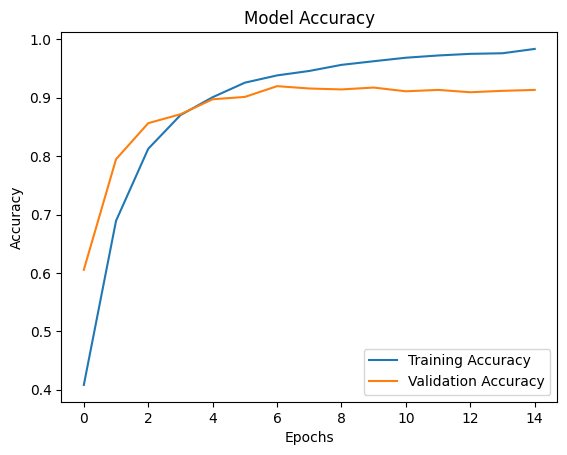

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()


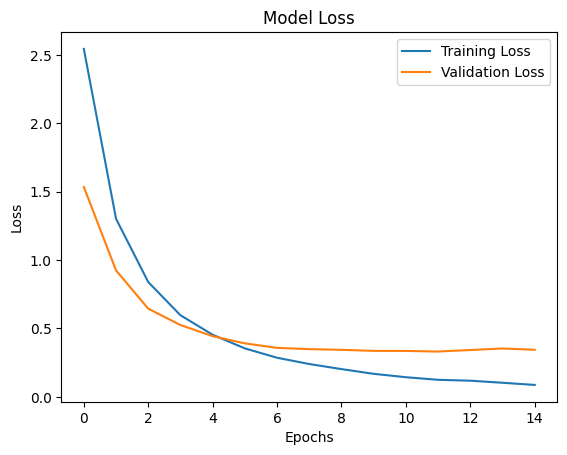

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()